In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("derrom/")

import derrom

In [2]:
I_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_I_kmax2.5_nkmax_100_n1000_v2.npz')
el_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_el_kmax2.5_nkmax_100_n1000_v2.npz')
el_scattering = derrom.utils.load_trajectories(filename='../PHELPH_el_scat_kmax2.5_nkmax_100_n1000_v2.npz')

n_sample = 1

I_trajectories = I_trajectories[::n_sample]
el_trajectories = el_trajectories[::n_sample]
el_scattering = el_scattering[::n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_I_trajectories = I_trajectories[:cutoff]
train_el_trajectories = el_trajectories[:cutoff]
train_el_scattering = el_scattering[:cutoff]

test_I_trajectories = I_trajectories[cutoff:]
test_el_trajectories = el_trajectories[cutoff:]
test_el_scattering = el_scattering[cutoff:]

1000 loaded with n_kmax = 100


In [3]:
dim_reducer = derrom.dim_reducers.SVD()
scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=500)
optimizer = derrom.optimizers.ridge(alpha=10.**-1)

model = derrom.derrom(train_el_trajectories, train_el_scattering, rdim=15, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  15
DE_l:  2
train shape:  (900900, 531)
target shape:  (900900, 100)
weights shape:  (531, 100)


In [4]:
ind = 5

test_el_trajectory = test_el_trajectories[ind]
truth = test_el_scattering[ind]

pred = model.predict(test_el_trajectory)

print( model.get_error(test_el_trajectory,truth,pred,norm='rms') ) 
print( model.get_error(test_el_trajectory,truth,norm='rms') ) 
print( model.get_error(truth=truth, pred=pred, norm='max') ) 

1.0445649629188195e-05
1.0445649629188195e-05
0.0003269675723459463


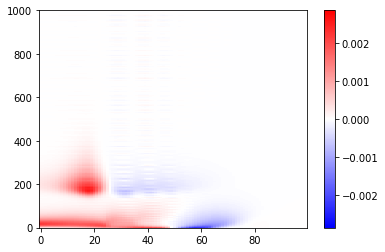

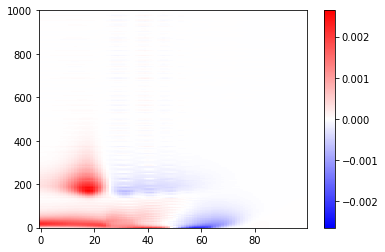

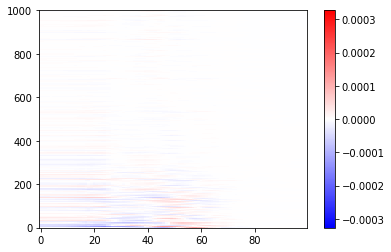

In [5]:
import matplotlib.colors as colors

plt.imshow(truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

plt.imshow(pred, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


plt.imshow(pred-truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


In [6]:
dim_reducer = derrom.dim_reducers.SVD()
scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=500)
optimizer = derrom.optimizers.ridge(alpha=10.**-1)

model = derrom.derrom(rdim=15, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)


scores = derrom.utils.get_KFold_CV_scores(model, el_trajectories, el_scattering, folds=10, seed=817,
                                          norms=['rms','max'],
                                          train_kwargs={})

print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

rms error:  1.0655604675027877e-05 +- 3.924923931774632e-06
max error:  0.00034618352162384635 +- 0.00020314382332623822


rms error:  1.0655604675027877e-05 +- 3.924923931774632e-06
max error:  0.00034618352162384635 +- 0.00020314382332623822


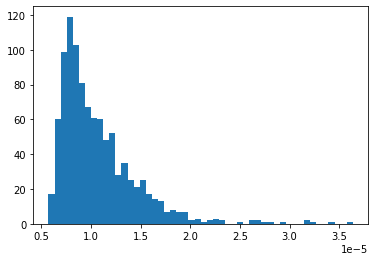

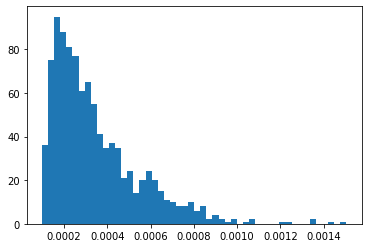

In [7]:
print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

plt.hist(scores[0],bins=50)
plt.show()

plt.hist(scores[1],bins=50)
plt.show()